In [0]:
import numpy as np
import pandas as pd

In [0]:
df= pd.read_json('/content/drive/My Drive/Projects/News-DataSet/News_Category_Dataset.json',lines=True)

In [3]:
df.head()

,short_description,headline,date,link,authors,category
0,She left her husband. He killed their children...,There Were 2 Mass Shootings In Texas Last Week...,2018-05-26,https://www.huffingtonpost.com/entry/texas-ama...,Melissa Jeltsen,CRIME
1,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2...,2018-05-26,https://www.huffingtonpost.com/entry/will-smit...,Andy McDonald,ENTERTAINMENT
2,The actor and his longtime girlfriend Anna Ebe...,Hugh Grant Marries For The First Time At Age 57,2018-05-26,https://www.huffingtonpost.com/entry/hugh-gran...,Ron Dicker,ENTERTAINMENT
3,The actor gives Dems an ass-kicking for not fi...,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,2018-05-26,https://www.huffingtonpost.com/entry/jim-carre...,Ron Dicker,ENTERTAINMENT
4,"The ""Dietland"" actress said using the bags is ...",Julianna Margulies Uses Donald Trump Poop Bags...,2018-05-26,https://www.huffingtonpost.com/entry/julianna-...,Ron Dicker,ENTERTAINMENT


In [4]:
df.short_description[0]

'She left her husband. He killed their children. Just another day in America.'

In [5]:
df.category.value_counts()
print('total number of different categories we have',df.category.value_counts().count())

total number of different categories we have 31


In [0]:
##Now it's time for the text cleaning 
import re
import nltk

In [0]:
#stop_words= stopwords.words('english')
#stemmer= SnowballStemmer('english')

In [0]:
#def preprocess(text, stem=False):
#    # Remove link,user and special characters
#    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
#    tokens = []
#    for token in text.split():
#        if token not in stop_words:
#            if stem:
#                tokens.append(stemmer.stem(token))
#            else:
#                tokens.append(token)
#    return " ".join(tokens)
#df.short_description = df.short_description.apply(lambda x: preprocess(x))

In [0]:
#df['short_description'][0]

In [0]:
##Now we are tokenising the text but before that

# as shown above, THE WORLDPOST and WORLDPOST should be the same category, so merge them.

df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)



In [0]:
#### It's better to add Short desciption and headline. It makes more sense

df['text']=df['headline'] + '. ' +df['short_description'] 

In [12]:
df['text'][0]

'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV. She left her husband. He killed their children. Just another day in America.'

In [0]:
#tokenizing
from keras_preprocessing.text import Tokenizer
tokenizer= Tokenizer()
tokenizer.fit_on_texts(df['text'])


In [0]:
X= tokenizer.texts_to_sequences(df.text)
df['words']=X

In [15]:
df['words'][0]

[87,
 95,
 260,
 917,
 2154,
 6,
 453,
 133,
 119,
 30,
 120,
 225,
 9,
 392,
 89,
 424,
 50,
 1003,
 38,
 323,
 44,
 202,
 51,
 185,
 73,
 6,
 168]

In [16]:
len(df['words'])

124989

In [0]:
df['words_length']= df.words.apply(lambda i:len(i))

df.words_length[0]

df= df[df['words_length']>=5]

In [18]:
df['words_length'].describe()

count    124068.000000
mean         26.128422
std          14.366390
min           5.000000
25%          17.000000
50%          24.000000
75%          32.000000
max         248.000000
Name: words_length, dtype: float64

In [19]:
####working on pad_sequences
from keras.preprocessing import sequence
max_length= 248
X=list(sequence.pad_sequences(df.words,maxlen=max_length,padding='post'))

Using TensorFlow backend.


In [20]:
X[0]

array([  87,   95,  260,  917, 2154,    6,  453,  133,  119,   30,  120,
        225,    9,  392,   89,  424,   50, 1003,   38,  323,   44,  202,
         51,  185,   73,    6,  168,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [0]:
categories = df.groupby('category').size().index.tolist()


In [22]:
len(categories)

30

In [0]:

categories = df.groupby('category').size().index.tolist()
category_int = {}
int_category = {}
for i, k in enumerate(categories):
    category_int.update({k:i})
    int_category.update({i:k})

df['c2id'] = df['category'].apply(lambda x: category_int[x])

In [0]:
word_index=tokenizer.word_index
###glove embedding

Eembedding_Size=200
glove= open('/content/drive/My Drive/pretrained-models/glove.6B.200d.txt')
embeddings_index = {}

for i in glove:
  values= i.split()
  word=values[0]
  coefs= np.asarray(values[1:],dtype='float32')
  embeddings_index[word]=coefs
glove.close() 


In [25]:
print('Found %s unique tokens.' % len(word_index))
print('Total %s word vectors.' % len(embeddings_index))

Found 86627 unique tokens.
Total 400000 word vectors.


In [26]:
embedding_matrix= np.zeros((len(word_index)+1,Eembedding_Size))
for word, i in word_index.items():
  embedding_vector=embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i]=embedding_vector
print(embedding_matrix.shape)


(86628, 200)


In [0]:
from keras.initializers import Constant

from keras.layers import Embedding
embedding_layer = Embedding(len(word_index)+1,
                            Eembedding_Size,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)

In [0]:
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
X = np.array(X)

Y=np_utils.to_categorical(list(df.c2id))

seeds=15
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=15)

In [0]:
from keras.layers import Bidirectional
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Conv1D
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(30, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 248, 200)          17325600  
_________________________________________________________________
dropout_1 (Dropout)          (None, 248, 200)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 30)                6030      
Total params: 17,572,430
Trainable params: 246,830
Non-trainable params: 17,325,600
_________________________________________________________________


In [31]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

##callbacks
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]


##train
history = model.fit(x_train, y_train,
                    batch_size=512,
                    epochs=10,
                    validation_data= (x_val ,y_val),
                    verbose=1,
                    callbacks=callbacks)

Train on 99254 samples, validate on 24814 samples
Epoch 1/10
99254/99254 [==============================] - 200s 2ms/step - loss: 2.3013 - accuracy: 0.3872 - val_loss: 1.7525 - val_accuracy: 0.5086
Epoch 2/10
99254/99254 [==============================] - 197s 2ms/step - loss: 1.7833 - accuracy: 0.4993 - val_loss: 1.5261 - val_accuracy: 0.5596
Epoch 3/10
99254/99254 [==============================] - 197s 2ms/step - loss: 1.6368 - accuracy: 0.5321 - val_loss: 1.4459 - val_accuracy: 0.5810
Epoch 4/10
99254/99254 [==============================] - 196s 2ms/step - loss: 1.5653 - accuracy: 0.5492 - val_loss: 1.3862 - val_accuracy: 0.5924
Epoch 5/10
99254/99254 [==============================] - 194s 2ms/step - loss: 1.5244 - accuracy: 0.5603 - val_loss: 1.3681 - val_accuracy: 0.5955
Epoch 6/10
99254/99254 [==============================] - 194s 2ms/step - loss: 1.4921 - accuracy: 0.5666 - val_loss: 1.3379 - val_accuracy: 0.6031
Epoch 7/10
99254/99254 [==============================] - 196s

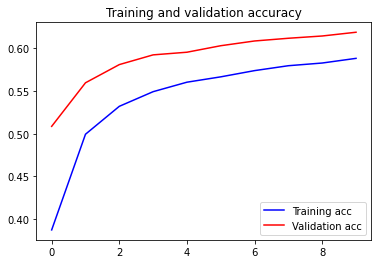

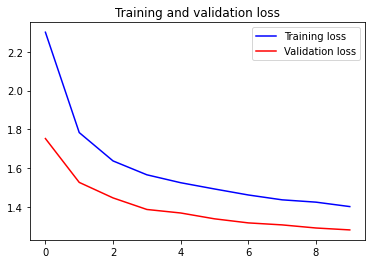

In [32]:
import matplotlib.pyplot as plt

acc= history.history['accuracy']
val_acc=history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']


epochs= range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [0]:
##### bidirectional LSTM+COV
from keras.layers import Dropout, LSTM, Dense, Conv1D, GlobalAveragePooling1D


Train on 99254 samples, validate on 24814 samples
Epoch 1/10
99254/99254 [==============================] - 108s 1ms/step - loss: 2.6828 - accuracy: 0.3130 - val_loss: 2.2755 - val_accuracy: 0.3875
Epoch 2/10


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


99254/99254 [==============================] - 107s 1ms/step - loss: 2.1665 - accuracy: 0.4101 - val_loss: 1.9248 - val_accuracy: 0.4716
Epoch 3/10
99254/99254 [==============================] - 106s 1ms/step - loss: 1.8943 - accuracy: 0.4768 - val_loss: 1.7068 - val_accuracy: 0.5219
Epoch 4/10
99254/99254 [==============================] - 106s 1ms/step - loss: 1.7221 - accuracy: 0.5175 - val_loss: 1.5601 - val_accuracy: 0.5581
Epoch 5/10
99254/99254 [==============================] - 106s 1ms/step - loss: 1.6056 - accuracy: 0.5445 - val_loss: 1.4650 - val_accuracy: 0.5814
Epoch 6/10
99254/99254 [==============================] - 106s 1ms/step - loss: 1.5283 - accuracy: 0.5638 - val_loss: 1.4159 - val_accuracy: 0.5934
Epoch 7/10
99254/99254 [==============================] - 106s 1ms/step - loss: 1.4746 - accuracy: 0.5771 - val_loss: 1.3764 - val_accuracy: 0.6008
Epoch 8/10
99254/99254 [==============================] - 106s 1ms/step - loss: 1.4311 - accuracy: 0.5857 - val_loss: 1.352

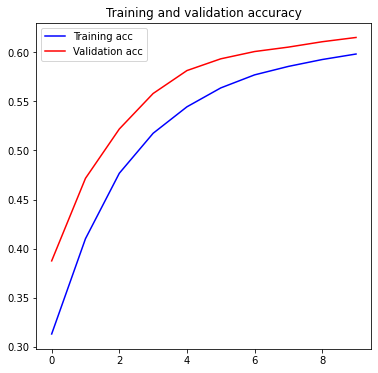

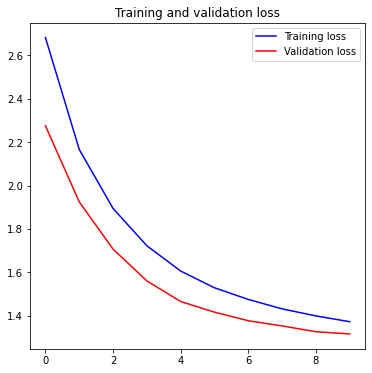

In [59]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2,return_sequences=True)))
model.add(Conv1D(64,kernel_size=3,strides=1))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling1D())
model.add(Dense(30, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])




##callbacks
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]


##train
history = model.fit(x_train, y_train,
                    batch_size=1024,
                    epochs=10,
                    validation_data=(x_val ,y_val),
                    verbose=1,
                    callbacks=callbacks)




acc= history.history['accuracy']
val_acc=history.history['val_accuracy']


loss = history.history['loss']
val_loss = history.history['val_loss']


epochs= range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()